In [2]:
import awkward as ak 
import numpy as np
import matplotlib.pyplot as plt
import fastjet
from coffea.nanoevents import NanoEventsFactory, EDM4HEPSchema
import dask_awkward as dak
import hist.dask as hda
import uproot

In [3]:
events = NanoEventsFactory.from_root( 
    {"../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004" 
    ".Pe2e2h.eR.pL.n000.d_dstm_15090_*.slcio.edm4hep.root"
#      ".Pe2e2h.eR.pL.n000.d_dstm_15090_2.slcio.edm4hep.root"
    :"events"},
    schemaclass=EDM4HEPSchema,
    permit_dask=True,
    metadata = {'b_field':5},
).events()

/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:63: UserWarning: Skipping PARAMETERS as it is it cannot be interpreted by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skipping _intMap as it is not interpretable by Uproot
  warnings.warn(
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.first as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:52: UserWarning: Skipping _intMap.second as it is not interpretable by Uproot
  warnings.warn(f"Skipping {branch.name} as it is not interpretable by Uproot")
/Users/josephinebrewster/TRIUMF-Summer-2023/coffea_dev/coffea/src/coffea/nanoevents/factory.py:45: UserWarning: Skippin

## Normal Slicing

In [87]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
# cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=2)

mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

select_clst = fastjet.ClusterSequence(events.PandoraPFOs[muonsevent], jetdef).exclusive_jets(n_jets=2)

# select_clst = cluster[muonsevent]

jets = dak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


{'from-uproot-c8373dc3d13bfd9ed187580b396f8534': ['PandoraPFOs.t',
  'PandoraPFOs.charge',
  'PandoraPFOs.pdgId',
  'PandoraPFOs.x',
  'PandoraPFOs.y',
  'PandoraPFOs.z']}

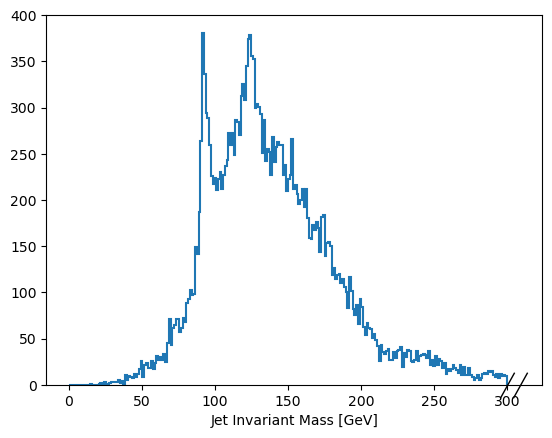

In [88]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) 


hist_jets = (
    hda.Hist.new.Reg(250, 0, 300, name="jet mass", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_jets.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

Post-Jet Slicing:

In [89]:
jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)
cluster = fastjet.ClusterSequence(events.PandoraPFOs, jetdef).exclusive_jets(n_jets=2)

mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

select_clst = cluster[muonsevent]

jets = dak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

{'from-uproot-c8373dc3d13bfd9ed187580b396f8534': ['PandoraPFOs.t',
  'PandoraPFOs.charge',
  'PandoraPFOs.pdgId',
  'PandoraPFOs.x',
  'PandoraPFOs.y',
  'PandoraPFOs.z']}

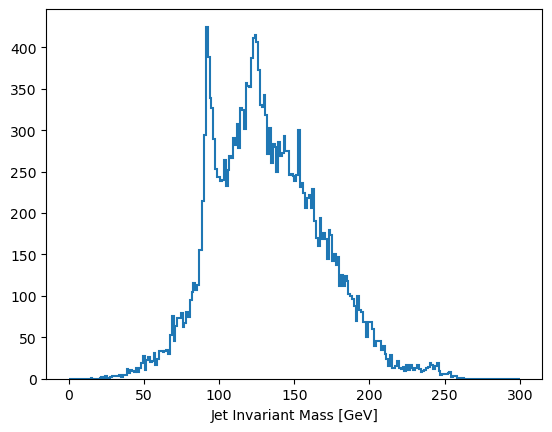

In [90]:
jetpair = dak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) 


hist_jets_POST = (
    hda.Hist.new.Reg(250, 0, 300, name="jet mass", label="Jet Invariant Mass [GeV]") 
    .Double()
    .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
)

hist_jets_POST.compute().plot1d(label='Jets')
dak.necessary_columns(hist_jets)

In [91]:
# pfo_index = fastjet.ClusterSequence(events.PandoraPFOs[muonsevent], jetdef).exclusive_jets_constituent_index(njets=2)

# # linked_gen = events.PandoraPFOs.matched_gen 
# # linked_pdg = linked_gen.pdgId[dak.flatten(pfo_index,axis=2)][muonsevent]

# linked_gen = events.PandoraPFOs[muonsevent].matched_gen
# linked_pdg = linked_gen.pdgId[dak.flatten(pfo_index,axis=2)]

# linked_pdg.compute()

Trying to write to disk to get around masking problem. Going to try comparing a basic case to make sure numbers and stuff are working.

In [92]:
%%time
xcom = events.PandoraPFOs[muonsevent].x.compute()
ycom = events.PandoraPFOs[muonsevent].y.compute()
zcom = events.PandoraPFOs[muonsevent].z.compute()
Ecom = events.PandoraPFOs[muonsevent].energy.compute()

CPU times: user 28.1 s, sys: 1.37 s, total: 29.5 s
Wall time: 32.5 s


In [93]:
%%time
x = []
y = []
z = []
E = []

for n in range(len(xcom)):
    x.append(np.array(xcom[n]))
    y.append(np.array(ycom[n]))
    z.append(np.array(zcom[n]))
    E.append(np.array(Ecom[n]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

CPU times: user 1min 17s, sys: 1.67 s, total: 1min 19s
Wall time: 1min 31s


In [94]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

In [95]:
pfo_index = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)

In [96]:
linked_gen = events.PandoraPFOs.matched_gen
linked_pdg = linked_gen.pdgId[muonsevent].compute()[ak.flatten(pfo_index,axis=2)]

In [97]:
select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)


jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#### Plot comparing different slicing stuff 

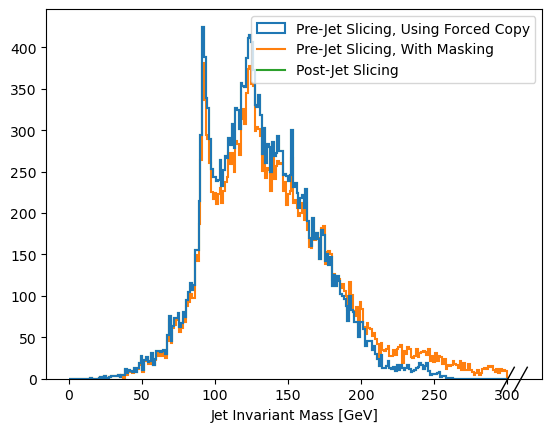

In [98]:
jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) 

nbins = 250
mini = 0 
maxi = 300

plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=1.5,
         label='Pre-Jet Slicing, Using Forced Copy')

# hist_jets = (
#     hda.Hist.new.Reg(250, 0, 300, name="jet mass", label="Jet Invariant Mass [GeV]") 
#     .Double()
#     .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
# )

hist_jets.compute().plot1d(label='Pre-Jet Slicing, With Masking')
dak.necessary_columns(hist_jets)

hist_jets_POST.compute().plot1d(label='Post-Jet Slicing')
dak.necessary_columns(hist_jets)

plt.legend()

## Trying this technique for inner-event slicing

In [4]:
mupair = dak.combinations(events.PandoraPFOs[abs(events.PandoraPFOs.pdgId) == 13], 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
muonsevent = dak.any(
    (pairmass > 80)
    & (pairmass < 100)
    & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)

jetdef = fastjet.JetDefinition(fastjet.kt_algorithm,1)

pfopair = dak.argcombinations(events.PandoraPFOs, 2, fields=["p1", "p2"])

invmass = (events.PandoraPFOs[pfopair.p1][(abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)] + events.PandoraPFOs[pfopair.p2][(abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)]).mass

inds = dak.singletons(dak.argmin(abs(invmass - 91.2), axis=1))


mu1ind = pfopair.p1[(abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)][inds]
mu2ind = pfopair.p2[(abs(events.PandoraPFOs[pfopair.p1].pdgId) == 13) & (abs(events.PandoraPFOs[pfopair.p2].pdgId) == 13)][inds]

In [5]:
m1 = mu1ind[muonsevent].compute()
m2 = mu2ind[muonsevent].compute()

p = events.PandoraPFOs[muonsevent].compute()

In [6]:
%%time
x = []
y = []
z = []
E = []

total_mask = []

local_inds = ak.local_index(p)

for n in range(len(p)):
    mask = (local_inds[n] != m1[n]) & (local_inds[n] != m2[n])
    total_mask.append(mask)
    
    x.append(np.array(p.x[n][mask]))
    y.append(np.array(p.y[n][mask]))
    z.append(np.array(p.z[n][mask]))
    E.append(np.array(p.E[n][mask]))

x = ak.Array(x)
y = ak.Array(y)
z = ak.Array(z)
E = ak.Array(E)

total_mask = ak.Array(total_mask)

# time 2min 50s

CPU times: user 3min 6s, sys: 1.61 s, total: 3min 8s
Wall time: 3min 15s


In [7]:
select_pfos = ak.zip(
    {
        'px': x,
        'py': y,
        'pz': z,
        'E': E,
    },
    with_name="LorentzVector",
)

In [8]:
select_clst = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets(n_jets=2)


jets = ak.zip(
    {
        'x': select_clst["px"],
        'y': select_clst["py"],
        'z': select_clst["pz"],
        't': select_clst["E"],
    },
    with_name="LorentzVector",
    behavior=events.PandoraPFOs.behavior,
)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


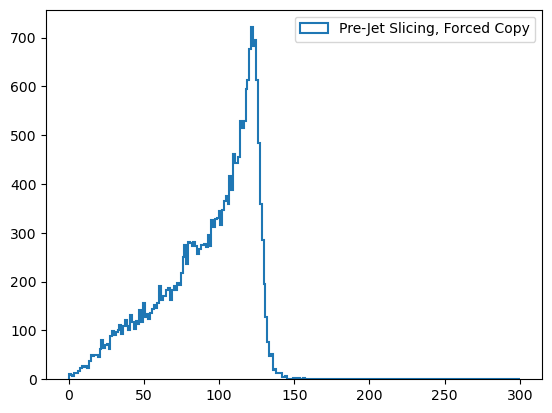

In [9]:
jetpair = ak.combinations(jets, 2, fields=["jet1", "jet2"],axis=1) # all jet pairs

nbins = 250
mini = 0 
maxi = 300

plt.close(1);plt.figure(1)
plt.hist(ak.flatten((jetpair.jet1 + jetpair.jet2).mass),
         bins=nbins,
         range=(mini,maxi),
         histtype='step',
         linewidth=1.5,
         label='Pre-Jet Slicing, Forced Copy')


# hist_clusters_2 = (
#     hda.Hist.new.Reg(250, 0, 300, name="energy", label="Jet Invariant Mass [GeV]") 
#     .Double()
#     .fill(dak.flatten((jetpair.jet1 + jetpair.jet2).mass))
# )

# hist_clusters_2.compute().plot1d(label='Pre-Jet Slicing, Masking')
# dak.necessary_columns(hist_clusters_2)

plt.legend()

In [10]:
pfo_index = fastjet.ClusterSequence(select_pfos, jetdef).exclusive_jets_constituent_index(njets=2)

In [11]:
linked_gen = events.PandoraPFOs.matched_gen
linked_pdg = linked_gen.pdgId[muonsevent].compute()[total_mask][ak.flatten(pfo_index,axis=2)]

## Comparing Jets to True Higgs

In [12]:
file = [uproot.open("../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004.Pe2e2h.eR.pL.n000.d_dstm_15090_0.slcio.edm4hep.root"),
        uproot.open("../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004.Pe2e2h.eR.pL.n000.d_dstm_15090_1.slcio.edm4hep.root"),
        uproot.open("../../coffea_dev/root_files_may18/rv02-02.sv02-02.mILD_l5_o1_v02.E250-SetA.I402004.Pe2e2h.eR.pL.n000.d_dstm_15090_2.slcio.edm4hep.root")]

evs = [file[n]['events'] for n in range(3)]

uproot_parinds_lst = [(evs[n][f'MCParticlesSkimmed#{0}/MCParticlesSkimmed#{0}.index']).array() for n in range(2,-1,-1)]
uproot_parinds = ak.concatenate(uproot_parinds_lst,axis=0)

uproot_daughinds_lst = [(evs[n][f'MCParticlesSkimmed#{1}/MCParticlesSkimmed#{1}.index']).array() for n in range(2,-1,-1)]
uproot_daughinds = ak.concatenate(uproot_daughinds_lst,axis=0)


In [13]:
def daughter_tree(event,start_ind):
    '''
    returns list of all daughters 
    '''
    curr_ind = ak.Array([-1])
    daugh_ind = ak.Array([start_ind])

    ind_lst = []

    flag = True

    while flag:
        curr_ind = daugh_ind

        daugh_ind = np.unique(ak.flatten(daugh_inds[event][curr_ind],axis=-1))

        ind_lst.append(list(curr_ind))

        if len(daugh_ind) == 0:
            flag = False 

    return ind_lst

In [14]:
pshape = (events.MCParticlesSkimmed.parents_end - events.MCParticlesSkimmed.parents_begin).compute()
par_inds = ak.unflatten(uproot_parinds,ak.flatten(pshape),axis=1)

dshape = (events.MCParticlesSkimmed.daughters_end - events.MCParticlesSkimmed.daughters_begin).compute()
daugh_inds = ak.unflatten(uproot_daughinds,ak.flatten(dshape),axis=1)

In [15]:
pdgids = events.MCParticlesSkimmed.pdgId.compute()

In [ ]:
%%time
higgs_daughter_tree = []

for event in range(len(pdgids)):
    start_ind = ak.local_index(pdgids[event])[pdgids[event] == 25][0]
    
    higgs_daughter_tree.append(daughter_tree(event,start_ind))
    
    if event % 1000 == 0:
        print(event)

higgs_daughter_tree_arr = ak.Array(higgs_daughter_tree)

higgs_children = ak.flatten(higgs_daughter_tree_arr,axis=2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000


In [ ]:
arr_reco = events.RecoMCTruthLink.reco_index.compute()
arr_mc = events.RecoMCTruthLink.mc_index.compute()
sort_reco = arr_reco[ak.argsort(arr_reco)]
sort_mc = arr_mc[ak.argsort(arr_reco)]


proper_indices = ak.unflatten(sort_mc,ak.flatten(ak.run_lengths(sort_reco),axis=1),axis=1)

#### Plots to make:
- number of missing/extra particles (I think I can just look at lengths)
- % of jet momentum coming from extra particles

In [ ]:
jet_mcindices = proper_indices[muonsevent.compute()][total_mask][ak.flatten(pfo_index,axis=2)]

# this just gets all the unique indices of mc inds
unique_jet_inds = ak.firsts(ak.unflatten(ak.sort(ak.flatten(jet_mcindices,axis=2)),ak.flatten(ak.run_lengths(ak.sort(ak.flatten(jet_mcindices,axis=2)))),axis=1),axis=2)

first_jet_inds = ak.firsts(jet_mcindices,axis=2)

all_jet_inds = ak.flatten(jet_mcindices,axis=2)


In [111]:
%%time
jet_con_in_higgs = []

for n in range(len(unique_jet_inds)):
    jet_con_in_higgs.append(np.isin(unique_jet_inds[n],higgs_children[n]))

jet_con_in_higgs = ak.Array(jet_con_in_higgs)

CPU times: user 31 s, sys: 639 ms, total: 31.6 s
Wall time: 34.1 s


In [167]:
%%time
jet_con_in_higgs = []

for n in range(len(unique_jet_inds)):
    jet_con_in_higgs.append(np.isin(first_jet_inds[n],higgs_children[n]))

jet_con_in_higgs = ak.Array(jet_con_in_higgs)

CPU times: user 38.2 s, sys: 2.03 s, total: 40.2 s
Wall time: 44.1 s


In [ ]:
%%time
jet_con_in_higgs = []

for n in range(len(unique_jet_inds)):
    jet_con_in_higgs.append(np.isin(all_jet_inds[n],higgs_children[n]))

jet_con_in_higgs = ak.Array(jet_con_in_higgs)

jet_con_in_higgs = ak.any(ak.unflatten(jet_con_in_higgs,ak.flatten(ak.num(jet_mcindices,axis=2)),axis=1),axis=2)

**how are you comparing?**

In [ ]:
def jet_in_higgs(weight_thres=0.5,):
    '''
    make a function to compare in different ways, possibly using a weight threshold, 
    or choosing the particle with the closest momentum
    '''
    

In [ ]:
ifig=1;plt.close(ifig);plt.figure(ifig)

nbins = 250
mini = 0 
maxi = 300

plt.hist((ak.num(jet_con_in_higgs)-ak.num(ak.local_index(jet_con_in_higgs)[jet_con_in_higgs]))/ak.num(jet_con_in_higgs),
         bins=nbins,
        )

plt.xlabel('number of extra particles in jets divided by number of particles in jets')

In [ ]:
ifig=2;plt.close(ifig);plt.figure(ifig)

nbins = 250
mini = 0 
maxi = 300

plt.hist(ak.flatten(events.PandoraPFOs[muonsevent].p.compute()[total_mask][ak.flatten(pfo_index,axis=2)][jet_con_in_higgs != True]),
         bins=nbins,
        )


plt.xlabel('momentum of extra particles [GeV]')

## Looking at Weights

In [ ]:
ak.fill_none(events.MCParticlesSkimmed.matched_pfos.compute(),0)